## Exploration & Exploitation

Open this [link](https://rl-lab.com/multi-armed-bandits/)

In [1]:
from abc import ABCMeta, abstractmethod, abstractproperty
import enum

import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

import pandas

import matplotlib.pyplot as plt
%matplotlib inline

## Bernoulli Bandit

In [2]:
class BernoulliBandit:
  def __init__(self, n_actions=5):
    self._probs = np.random.random(n_actions)

  @property
  def action_count(self):
    return len(self._probs)

  def pull(self, action):
    if np.random.random() > self._probs[action]:
      return 0.0
    else: return 1.0
  def optimal_reward(self):
    return np.max(self._probs)

  def reset(self):
    pass
  def step(self):
    pass


In [3]:
class AbstractAgent(metaclass=ABCMeta):
    def init_actions(self, n_actions):
        self._successes = np.zeros(n_actions)
        self._failures = np.zeros(n_actions)
        self._total_pulls = 0

    @abstractmethod
    def get_action(self):
        """
        Get current best action
        :rtype: int
        """
        pass

    def update(self, action, reward):
        """
        Observe reward from action and update agent's internal parameters
        :type action: int
        :type reward: int
        """
        if reward == 1:
          self._successes[action] += 1
        else:
          self._failures[action] += 1
        self._total_pulls += 1

    @property
    def name(self):
        return self.__class__.__name__


class RandomAgent(AbstractAgent):
    def get_action(self):
        np.random.randint(0, len(self._failures))

### Epsilon-greedy agent

In [4]:
class EpsilonGreedyAgent(AbstractAgent):
    def __init__(self, epsilon=0.2):
        super().init_actions(n_actions=5)  # Initialize actions for 5 possible actions
        self._epsilon = epsilon

    def get_action(self):
        """
        Selects an action based on the epsilon-greedy strategy.
        """
        if np.random.random() < self._epsilon:
            # Explore: select a random action
            return np.random.randint(0, len(self._successes))
        else:
            # Exploit: select the action with the highest estimated Q-value
            q = self._successes / (self._successes + self._failures + 1e-5)  # Avoid division by zero
            return np.argmax(q)

    @property
    def name(self):
        return self.__class__.__name__ + "(epsilon={})".format(self._epsilon)

### Decaying Epsilon-greedy agent:

In [5]:
class DecayingEpsilonGreedyAgent(AbstractAgent):
    def __init__(self, epsilon=0.2):
        self._epsilon = epsilon

    def get_action(self):
      if np.random.random() < self._epsilon:
          return np.random.randint(len(self._successes))
      else:
          return np.argmax(self._successes/(self._successes + self._failures + 0.01))

      self._epsilon  = self._epsilon * 0.9999


    @property
    def name(self):
        return self.__class__.__name__

### UCB Agent

In [6]:
class UCBAgent(AbstractAgent):
    def get_action(self):

        w = self._successes  / (self._successes + self._failures+0.01) + np.sqrt(2 * np.log(self._total_pulls + 0.01) / (self._successes + self._failures + 0.01))
        return np.argmax(w)

In [7]:
from collections import OrderedDict

def get_regret(env, agents, n_steps=5000, n_trials=50):
    scores = OrderedDict({
        agent.name: [0.0 for step in range(n_steps)] for agent in agents
    })

    for trial in range(n_trials):
        env.reset()

        for a in agents:
            a.init_actions(env.action_count)

        for i in range(n_steps):
            optimal_reward = env.optimal_reward()

            for agent in agents:
                action = agent.get_action()
                reward = env.pull(action)
                agent.update(action, reward)
                scores[agent.name][i] += optimal_reward - reward

            env.step()  # change bandit's state if it is unstationary

    for agent in agents:
        scores[agent.name] = np.cumsum(scores[agent.name]) / n_trials

    return scores

def plot_regret(agents, scores):
    for agent in agents:
        plt.plot(scores[agent.name])

    plt.legend([agent.name for agent in agents])

    plt.ylabel("regret")
    plt.xlabel("steps")

    plt.show()

<ipython-input-6-d8ce1ea5f0c5>:4: RuntimeWarning: invalid value encountered in sqrt
  w = self._successes  / (self._successes + self._failures+0.01) + np.sqrt(2 * np.log(self._total_pulls + 0.01) / (self._successes + self._failures + 0.01))


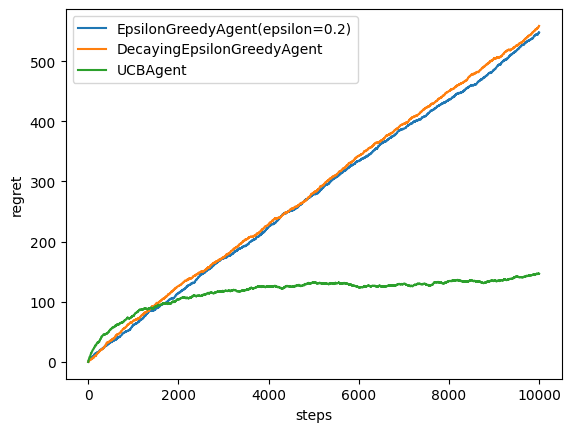

In [8]:
# Uncomment agents
agents = [
    EpsilonGreedyAgent(),
    DecayingEpsilonGreedyAgent(),
    UCBAgent(),
]

regret = get_regret(BernoulliBandit(), agents, n_steps=10000, n_trials=10)
plot_regret(agents, regret)

### Bayesian Bandits (Thompson Sampling)

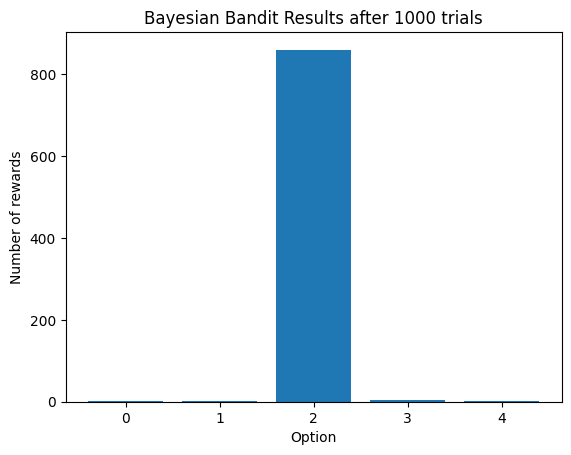

[0.4, 0.3, 0.9, 0.2, 0.1]


In [9]:
import numpy as np
import matplotlib.pyplot as plt

class BayesianBandit:
    def __init__(self, num_machines):
        self.num_machines = num_machines
        self.alpha = np.ones(num_machines)    # prior of 1 for each machine
        self.beta = np.ones(num_machines)     # prior of 1 for each machine
        self.real_winning_rate = [round(np.random.random(), 1) for _ in range(num_machines)] # the real winning rate of machines. #### THIS PART IS UNKOWN FOR THE AGENT.

    def choose_machine(self):
        theta = np.random.beta(self.alpha, self.beta)    # sample theta values from Beta distribution
        return np.argmax(theta)    # choose the machine with highest theta value

    def update(self, machine, reward):
        self.alpha[machine] += reward    # update alpha with reward
        self.beta[machine] += 1 - reward    # update beta with non-reward

    def take_action(self, machine):
        return 1 if self.real_winning_rate[machine] > np.random.random()  else 0

# Example usage:
num_machines = 5
num_trials = 1000
bandit = BayesianBandit(num_machines)
rewards = np.zeros(num_machines)

for i in range(num_trials):
    machine = bandit.choose_machine()
    # reward = np.random.binomial(1, 0.5)    # simulate reward with 50% probability
    reward = bandit.take_action(machine)
    rewards[machine] += reward
    bandit.update(machine, reward)

# Plot the results:
x = np.arange(num_machines)
plt.bar(x, rewards)
plt.title('Bayesian Bandit Results after {} trials'.format(num_trials))
plt.xlabel('Option')
plt.ylabel('Number of rewards')
plt.show()
# print([(a,b)for a,b in zip(bandit.alpha, bandit.beta)])
print(bandit.real_winning_rate)
